In [1]:
# Load packages:
import numpy as np
import pandas as pd
from datetime import datetime
from collections import Counter

#import pickleshare

## Table of content:

   - Load datasets
   - Scheduled maintenance
   - Corrective maintenance

Maintenances info are extracted from the csv.

There is one issue for both maintenances: dates of start and end are not the true ones, except for the end dates of ordinary maintenances.

The goal here is to approximate the missing dates in order to have complete info for each maintenance, so that:
- end dates will be used to define the variables in the log data
- start and end dates will be used to get some statistics and to perform some eda

### Load dataset:
Dataset of scheduled maintenances, corrective maintenances and raw log are loaded. The latter is needed in order to find the starting dates for both scheduled and corrective maintenances 

In [2]:
# Load the 2 maintenance:
scheduled_maintenance = pd.read_csv('..//csv_maintenances_services//FileEstratti//Manutezione_Programmata.csv', delimiter=';', dtype={
    'Convoglio': 'category',
    'Revisione': 'category',
    'Livello manutenzione': 'category'
})

scheduled_maintenance = scheduled_maintenance.rename(columns={'Convoglio': 'Train',
                                                              'Revisione': 'Type',
                                                              'Livello manutenzione': 'Level'})

corrective_maintenance = pd.read_csv('..//csv_maintenances_services//FileEstratti//Manutenzione_Straordinaria_040.csv', delimiter=';', dtype={
    'Campo sort': 'category',
    'Sede tecnica': 'category',
    'Tipo avviso': 'category',
    'Descr. assem. Padre': 'category'
})
corrective_maintenance = corrective_maintenance.rename(columns={'Campo sort': 'Train',
                                                              'Sede tecnica': 'Wagon',
                                                              'Tipo avviso': 'Type',
                                                              'Descr. assem. Padre': 'Group_maint_source',})
#corrective_maintenance = corrective_maintenance.drop(columns=['Unnamed: 7'])

print(f"Scheduled maintenance dataset: \n{scheduled_maintenance.head()}")
print("\n")
print(f"Corrective maintenance dataset: \n{corrective_maintenance.head()}")
print("\n")

Scheduled maintenance dataset: 
               Train Type Level Data fine revisione  \
0  TSR 020 (3 casse)   RP     1          2020-06-10   
1  TSR 017 (3 casse)   RT     1          2020-06-16   
2  TSR 008 (3 casse)   VI     1          2020-06-17   
3  TSR 064 (5 casse)   RT     1          2020-06-18   
4  TSR 059 (5 casse)   VI     1          2020-07-04   

   Chilometri del treno al termine della revisione  
0                                          1211297  
1                                          1320232  
2                                          1468074  
3                                          1484023  
4                                          1255257  


Corrective maintenance dataset: 
         Avviso   Train    Wagon    N. invent. Type Inizio guasto Fine guasto  \
0  100001670601  R040-6  710-170  948367101706   T3    2020-09-12  2020-09-14   
1  100001672624  R040-6  710-170  948367101706   T3    2020-09-16  2020-09-17   
2  100001673436  R040-6  710-170  9483671

In [3]:
# Load entire (and raw) log data:
df = pd.read_csv('Workset_dataset//modified_TSR_040.csv', delimiter=',')
df = df.rename(columns={'Sorgente_Dati': 'source',
                            'Vettura': 'name',
                            'Monitor': 'machine_type',
                            'Tipo': 'alert_type',
                            'Unix_timestamp(ms)': 'ts',
                            'Gruppo': 'cod',
                            'PdM': 'id',
                            'PdO': 'id1',
                            'Evento': 'event_type',
                            'Master': 'master',
                            'Pantografo': 'pantograph',
                            'Velocità': 'speed',
                            'Latitudine': 'lat',
                            'Longitudine': 'lon',
                            'extra': 'extra',
                            'Deposito': 'depot'
                            })


df['ts_UTC'] = pd.to_datetime(df['ts'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('Europe/Rome')
df['Time']  = df['ts_UTC'].dt.floor('s',ambiguous=False).dt.tz_localize(None,ambiguous=False)
df = df.drop(columns=['ts_UTC'])
df['Date'] = pd.to_datetime(df['Time']).dt.date
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')
data = df.sort_values(by='Date')
data = data.reset_index(drop=True)
data2 = data[data['cod'] != 7]
data2 = data2.reset_index(drop=True)

print(f"Raw dataset: \n{data2.head()}")     # length: 1240609
print("\n")
print(data2.info())
print("\n")
print(data2['Date'].unique())               # length: 1068

Raw dataset: 
    source     name machine_type alert_type             ts  cod  id  id1  \
0  711-083  710-170           MD        PDM  1604725173000    5  15    0   
1  711-083  710-131           MS        PDM  1604763607000    5  15    0   
2  711-083  710-170           MS        PDM  1604763607000    5  15    0   
3  711-083  710-131           MD        PDM  1604763622000    5  15    0   
4  711-083  710-170           MD        PDM  1604763622000    5  15    0   

  event_type          master  pantograph  speed      lat      lon extra  \
0         ON  Master Assente         NaN     22  45.6522  9.13974   NaN   
1         ON         711-083         NaN      0  45.4695  9.17389   NaN   
2         ON         711-083         NaN      0  45.4695  9.17389   NaN   
3         ON         711-083         NaN      0  45.4695  9.17389   NaN   
4         ON         711-083         NaN      0  45.4695  9.17389   NaN   

   depot                Time       Date  
0      0 2020-11-07 05:59:33 2020-11

### Scheduled maintenance
For each scheduled maintenance there is only the end date, therefore the start date is found using the raw log data

In [4]:
print(scheduled_maintenance.head())
print("\n")
print(scheduled_maintenance.info())

               Train Type Level Data fine revisione  \
0  TSR 020 (3 casse)   RP     1          2020-06-10   
1  TSR 017 (3 casse)   RT     1          2020-06-16   
2  TSR 008 (3 casse)   VI     1          2020-06-17   
3  TSR 064 (5 casse)   RT     1          2020-06-18   
4  TSR 059 (5 casse)   VI     1          2020-07-04   

   Chilometri del treno al termine della revisione  
0                                          1211297  
1                                          1320232  
2                                          1468074  
3                                          1484023  
4                                          1255257  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 5 columns):
 #   Column                                           Non-Null Count  Dtype   
---  ------                                           --------------  -----   
 0   Train                                            250 non-null    category
 1   Typ

In [5]:
scheduled_maintenance["Chilometri del treno al termine della revisione"].max()

1930806

In [6]:
# 1) converting datetime and converting km:

#   a) km end:
#scheduled_maintenance['Km'] = (scheduled_maintenance['Chilometri del treno al termine della revisione'].str.replace(',', '')).astype(int)
scheduled_maintenance['Km'] = scheduled_maintenance['Chilometri del treno al termine della revisione']


#   b) date:
#scheduled_maintenance['End_date'] = pd.to_datetime(pd.to_datetime(scheduled_maintenance['Data fine revisione'],format='%d/%m/%Y').dt.strftime('%Y-%m-%d'), format='%Y-%m-%d')
scheduled_maintenance['End_date'] = pd.to_datetime(pd.to_datetime(scheduled_maintenance['Data fine revisione']).dt.strftime('%Y-%m-%d'), format='%Y-%m-%d')
print(scheduled_maintenance['End_date'].unique())
print("\n")
print(scheduled_maintenance['End_date'])


# check entire dataset:
print("\n")
print(scheduled_maintenance.info())

<DatetimeArray>
['2020-06-10 00:00:00', '2020-06-16 00:00:00', '2020-06-17 00:00:00',
 '2020-06-18 00:00:00', '2020-07-04 00:00:00', '2020-07-06 00:00:00',
 '2020-07-23 00:00:00', '2020-07-28 00:00:00', '2020-07-29 00:00:00',
 '2020-07-31 00:00:00',
 ...
 '2024-03-14 00:00:00', '2024-03-27 00:00:00', '2024-04-10 00:00:00',
 '2024-04-12 00:00:00', '2024-04-15 00:00:00', '2024-04-16 00:00:00',
 '2024-04-19 00:00:00', '2024-04-24 00:00:00', '2024-04-27 00:00:00',
 '2024-05-24 00:00:00']
Length: 225, dtype: datetime64[ns]


0     2020-06-10
1     2020-06-16
2     2020-06-17
3     2020-06-18
4     2020-07-04
         ...    
245   2024-04-19
246   2024-04-24
247   2024-04-24
248   2024-04-27
249   2024-05-24
Name: End_date, Length: 250, dtype: datetime64[ns]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                  

In [7]:
# 2) filter on TSR 040:
print(scheduled_maintenance['Train'].unique())
print("\n")
sched_maint_040 = scheduled_maintenance[scheduled_maintenance['Train'] == 'TSR 040 (6 casse)']
sched_maint_040 = sched_maint_040.reset_index(drop=True)
print(sched_maint_040.head())
print("\n")
print(sched_maint_040.info())

['TSR 020 (3 casse)', 'TSR 017 (3 casse)', 'TSR 008 (3 casse)', 'TSR 064 (5 casse)', 'TSR 059 (5 casse)', 'TSR 086 (6 casse)', 'TSR 033 (6 casse)', 'TSR 040 (6 casse)', 'TSR 070 (5 casse)']
Categories (9, object): ['TSR 008 (3 casse)', 'TSR 017 (3 casse)', 'TSR 020 (3 casse)', 'TSR 033 (6 casse)', ..., 'TSR 059 (5 casse)', 'TSR 064 (5 casse)', 'TSR 070 (5 casse)', 'TSR 086 (6 casse)']


               Train Type Level Data fine revisione  \
0  TSR 040 (6 casse)  VIS     2          2020-08-26   
1  TSR 040 (6 casse)   VI     1          2020-08-28   
2  TSR 040 (6 casse)   R4     1          2020-08-28   
3  TSR 040 (6 casse)   RP     1          2020-08-28   
4  TSR 040 (6 casse)   VI     1          2020-10-22   

   Chilometri del treno al termine della revisione      Km   End_date  
0                                           955258  955258 2020-08-26  
1                                           955258  955258 2020-08-28  
2                                           955258  955258 2020

In [8]:
# 3) find start date of each maintenance from log data --> idea is to find the proxy of the start date for each maintenance as the first alert with depot=0 before the end of the maintenance:

#print(sched_maint_040['End_date'])             # =29
#print(sched_maint_040['End_date'].unique())    # =27

#   a) take the alerts with depot=1 and date=end_date of the maintenances (unique):
log_enddate_depot1 = pd.DataFrame()
for i in sched_maint_040['End_date'].unique():
    mask = data2[(data2['Date'] == i) & (data2['depot'] == 1)]
    log_enddate_depot1 = pd.concat([log_enddate_depot1, mask])
    #log_during_maintenance.loc[len(mask)] = mask
#log_enddate_depot1.reset_index(drop=True, inplace=True)
print(f"len of log_enddate_depot1: {len(log_enddate_depot1)}")   # length: 6884
print("\n")
print(f"head of log_enddate_depot1: \n{log_enddate_depot1.head()}")


#   b) we need only the first alert for each different end_date:
log_enddate_depot1_dropped = log_enddate_depot1.drop_duplicates('Date', keep='first')
print("\n")
print(f"log_enddate_depot1_dropped: \n{log_enddate_depot1_dropped}")


#   c) we search for the first alert with depot=0 before each of the alerts end_date and depot=1:
index = log_enddate_depot1_dropped.index
print("\n")
print(f"index: {index}")
print(f"len of index: {len(index)}")

start_date = []
for i in index:
    for k in range(1, 900):
        riga = data2.loc[i-k]
        if(riga['depot'] == 0):
            start_date.append(riga['Date'])
            break
print("\n")
print(f"start dates: {start_date}")
print(f"len of start dates: {len(start_date)}")


#   d) combine start and end date of the maintenances:
log_enddate_depot1_dropped['start_date'] = start_date
#print(log_enddate_depot1_dropped)
dataset_appoggio = log_enddate_depot1_dropped[['Date','start_date']]
dataset_appoggio = dataset_appoggio.rename(columns={'Date': 'End_Date',
                                                    'start_date': 'Start_Date'})
dataset_appoggio['Duration'] = dataset_appoggio.apply(lambda x: x['End_Date'] - x['Start_Date'] + pd.Timedelta(days=1), axis=1)
print("\n")
print(f"start, end, duration of unique maintenances: \n{dataset_appoggio}")


#   e) add start date and duration to each scheduled maintenance:
print("\n")
prova = sched_maint_040['End_date'].isin(dataset_appoggio['End_Date'])
print(prova)
print("\n")
sched_maint_040['boolean'] = prova
print(sched_maint_040)
print("\n")
print(sched_maint_040['boolean'])
print("\n")
start_date_complete = []
duration_complete = []
for i in range(len(sched_maint_040)):
    print(i)
    if sched_maint_040.loc[i, 'boolean'] == True:
        index_to_apply = dataset_appoggio.index[dataset_appoggio['End_Date'] == sched_maint_040.loc[i, 'End_date']].tolist()
        print(index_to_apply)
        print(dataset_appoggio.loc[index_to_apply, 'Start_Date'].iat[0])
        print(dataset_appoggio.loc[index_to_apply, 'Duration'].iat[0])
        start_date_complete.append(dataset_appoggio.loc[index_to_apply, 'Start_Date'].iat[0])
        duration_complete.append(dataset_appoggio.loc[index_to_apply, 'Duration'].iat[0])
    else:
        start_date_complete.append("no log")
        duration_complete.append("no log")
        print("no log")
print("\n")
print(f"start date column: \n{start_date_complete}")
print(f"duration column: \n{duration_complete}")
sched_maint_040['Start_date'] = start_date_complete
sched_maint_040['Duration'] = duration_complete
print("\n")
print(sched_maint_040)


# f) create the final version:
#print(sched_maint_040.columns)
sched_maint_040_complete = sched_maint_040.drop(columns=['Data fine revisione', 'Chilometri del treno al termine della revisione', 'boolean'])
sched_maint_040_complete = sched_maint_040_complete[['Train', 'Type', 'Level', 'Km', 'Start_date', 'End_date', 'Duration']]
print("\n")
print(sched_maint_040_complete)
print("\n")
print(sched_maint_040_complete.info())
# start_date and duration are "objects" --> convert them into datetime and timedelta:
sched_maint_040_complete['Start_date_all_dates'] = sched_maint_040_complete['Start_date'].apply(lambda x: pd.to_datetime(pd.NaT) if x == 'no log' else pd.to_datetime(x))
sched_maint_040_complete['Duration_all_timedelta'] = sched_maint_040_complete['Duration'].apply(lambda x: pd.Timedelta(0) if x == 'no log' else pd.Timedelta(x))
sched_maint_040_complete = sched_maint_040_complete.drop(columns=['Start_date', 'Duration'])
print("\n")
sched_maint_040_complete = sched_maint_040_complete[['Train', 'Type', 'Level', 'Km', 'Start_date_all_dates', 'End_date', 'Duration_all_timedelta']]
sched_maint_040_complete.rename(columns={'Start_date_all_dates': 'Start_date', 'Duration_all_timedelta': 'Duration'}, inplace=True)
print(sched_maint_040_complete.info())
print("\n")
print(sched_maint_040_complete)
print("\n")

len of log_enddate_depot1: 6884


head of log_enddate_depot1: 
        source     name machine_type alert_type             ts  cod  id  id1  \
27874  711-084  711-084           MS        PDM  1608168248000    5   1    0   
27875  711-084  711-083           MS        PDM  1608168514000    2   3    0   
27876  711-084  711-083           MS        PDM  1608168514000    2   4    0   
27877  711-084  711-083           MS        PDM  1608168514000    2   6    0   
27878  711-084  711-083           MS        PDM  1608168514000    2  14    0   

      event_type          master  pantograph  speed      lat      lon extra  \
27874         ON  Master Assente         NaN      0  45.6658  9.13474   NaN   
27875         ON  Master Assente         NaN      0  45.6658  9.13473   NaN   
27876         ON  Master Assente         NaN      0  45.6658  9.13473   NaN   
27877         ON  Master Assente         NaN      0  45.6658  9.13473   NaN   
27878         ON  Master Assente         NaN      0  45.6658 

/tmp/ipykernel_2364674/1927183308.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_enddate_depot1_dropped['start_date'] = start_date


In [9]:
# 4) extract some info:
print(f"-how many scheduled maintenance done between 2020 and 2024?: {len(sched_maint_040_complete)}")
print(f"-which type of maintenance done between 2020 and 2024?: \n{sched_maint_040_complete['Type'].value_counts()}")
diff_duration_sched = Counter(sched_maint_040_complete['Duration'])
ordered_diff_duration_sched = sorted(diff_duration_sched.items())
print("-how long the maintenances?:")
for diff_duration, count in ordered_diff_duration_sched:
    print(f"{diff_duration}: {count} occurrences")

-how many scheduled maintenance done between 2020 and 2024?: 29
-which type of maintenance done between 2020 and 2024?: 
Type
VI     13
RT     11
RP      2
R4      1
RD      1
VIS     1
Name: count, dtype: int64
-how long the maintenances?:
0 days 00:00:00: 8 occurrences
1 days 00:00:00: 9 occurrences
2 days 00:00:00: 10 occurrences
3 days 00:00:00: 2 occurrences


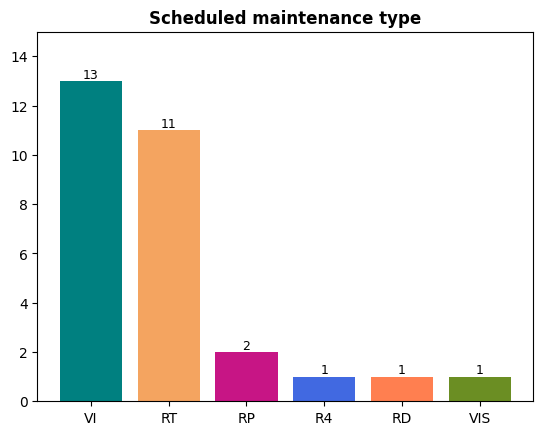

In [16]:
# plot:
import matplotlib.pyplot as plt
size_type = sched_maint_040_complete['Type'].value_counts().tolist()
label_type = sched_maint_040_complete['Type'].value_counts().index

fig, ax = plt.subplots()
bar_container = ax.bar(label_type, size_type, color=['teal', 'sandybrown', 'mediumvioletred', 'royalblue', 'coral', 'olivedrab'])
ax.bar_label(bar_container, fmt='{:,.0f}', fontsize=9)
ax.set_title('Scheduled maintenance type', fontweight='bold')
ax.set_ylim(0, 15)
plt.savefig('sched_maint_type.png', transparent=True)
plt.show()




In [17]:
# 5) check alerts during the scheduled maintenances:
start_sched_maint = sched_maint_040_complete['Start_date']
end_sched_maint = sched_maint_040_complete['End_date']
#print(start_sched_maint)
#print("\n")
#print(end_sched_maint)
#print("\n")

#print(len(list(zip(start_sched_maint, end_sched_maint))))
#print(list(zip(start_sched_maint, end_sched_maint)))
#print("\n")


#   a) all alerts:
log_during_sched_maintenance = pd.DataFrame()
for start, end in zip(start_sched_maint, end_sched_maint):
    #print(f"-maintenance from {start} to {end} :")
    mask = data2[(data2['Date'] >= start) & (data2['Date'] <= end)]
    #print(mask)
    #print("\n")
    log_during_sched_maintenance = pd.concat([log_during_sched_maintenance, mask])
    #log_during_maintenance.loc[len(mask)] = mask
log_during_sched_maintenance.reset_index(drop=True, inplace=True)

print("all alerts during maintenances:")
print(log_during_sched_maintenance)   # length: 21212
print("\n")
print(log_during_sched_maintenance['depot'].value_counts())   # 0-->12165 and 1-->9047
print("\n")


#   b) alerts in depot:
print("b) alerts in depot during maintenances:")
log_sched_maintenance_depot1 = log_during_sched_maintenance[log_during_sched_maintenance['depot'] == 1]
print("\n")

count_no_alert = 0
end_no_alert = []
for start, end in zip(start_sched_maint, end_sched_maint):
    print(f"-maintenance from {start} to {end} :")
    mask = log_sched_maintenance_depot1[(log_sched_maintenance_depot1['Date'] >= start) & (log_sched_maintenance_depot1['Date'] <= end)]
    print(f"type of the maintenance: {sched_maint_040_complete[(sched_maint_040_complete['Start_date'] >= start) & (sched_maint_040_complete['End_date'] <= end)]['Type'].tolist()}")
    print(f"how many alerts: {len(mask)}")
    print(f"where alerts have been tested during the maintenance: \n{mask['name'].value_counts()}")
    print("\n")
    if len(mask) == 0:
        count_no_alert += 1
        end_no_alert.append(end)
print(count_no_alert)   # =8
print(end_no_alert)

all alerts during maintenances:
        source     name machine_type alert_type             ts  cod  id  id1  \
0      711-084  711-084           MD        PDO  1608134141000    5  11    2   
1      711-084  710-170           MS        PDM  1608123946000    5   1    0   
2      711-084  711-083           MS        PDM  1608125093000    2   6    0   
3      711-084  711-083           MS        PDM  1608125093000    2   4    0   
4      711-084  711-083           MS        PDM  1608125093000    2   3    0   
...        ...      ...          ...        ...            ...  ...  ..  ...   
21207  711-084  710-170           MD        PDO  1713482477000    5  11    7   
21208  711-084  711-084           MD        PDO  1713482475000    5  99   11   
21209  711-084  710-170           MD        PDO  1713482475000    5  99   11   
21210  711-084  711-084           MD        PDO  1713482474000    5  98   30   
21211  711-084  710-170           MD        PDO  1713482478000    5  98   30   

      e

### Corrective maintenance
For each corrective maintenance there is the start and end date of the fault's warn. Assuming that the end date correspond to the real end of the maintenance, the start date has to be estimated using the raw log data

In [18]:
# 1) converting dates:

#   a) start date:
#corrective_maintenance['Start_date'] = pd.to_datetime(pd.to_datetime(corrective_maintenance['Inizio guasto'],format='%d/%m/%Y').dt.strftime('%Y-%m-%d'), format='%Y-%m-%d')
corrective_maintenance['Start_date'] = pd.to_datetime(pd.to_datetime(corrective_maintenance['Inizio guasto']).dt.strftime('%Y-%m-%d'), format='%Y-%m-%d')
print(corrective_maintenance['Start_date'].unique())
print("\n")
print(corrective_maintenance['Start_date'])


#   b) end date:
#corrective_maintenance['End_date'] = pd.to_datetime(pd.to_datetime(corrective_maintenance['Fine guasto'],format='%d/%m/%Y').dt.strftime('%Y-%m-%d'), format='%Y-%m-%d')
corrective_maintenance['End_date'] = pd.to_datetime(pd.to_datetime(corrective_maintenance['Fine guasto']).dt.strftime('%Y-%m-%d'), format='%Y-%m-%d')
print(corrective_maintenance['End_date'].unique())
print("\n")
print(corrective_maintenance['End_date'])


# check entire dataset:
print("\n")
print(corrective_maintenance.info())
print(corrective_maintenance.tail())
corrective_maintenance = corrective_maintenance.iloc[:-1]
print(corrective_maintenance.tail())

<DatetimeArray>
['2020-09-12 00:00:00', '2020-09-16 00:00:00', '2020-09-17 00:00:00',
 '2020-09-21 00:00:00', '2020-09-25 00:00:00', '2020-09-27 00:00:00',
 '2020-09-29 00:00:00', '2020-10-01 00:00:00', '2020-10-03 00:00:00',
 '2020-10-10 00:00:00',
 ...
 '2024-04-13 00:00:00', '2024-04-17 00:00:00', '2024-05-20 00:00:00',
 '2024-05-23 00:00:00', '2024-05-30 00:00:00', '2024-05-31 00:00:00',
 '2024-06-08 00:00:00', '2024-06-09 00:00:00', '2024-06-10 00:00:00',
 '2024-06-20 00:00:00']
Length: 128, dtype: datetime64[ns]


0     2020-09-12
1     2020-09-16
2     2020-09-17
3     2020-09-21
4     2020-09-25
         ...    
148   2024-06-08
149   2024-06-09
150   2024-06-10
151   2024-06-20
152   2024-06-20
Name: Start_date, Length: 153, dtype: datetime64[ns]
<DatetimeArray>
['2020-09-14 00:00:00', '2020-09-17 00:00:00', '2020-09-22 00:00:00',
 '2020-09-27 00:00:00', '2020-09-30 00:00:00', '2020-10-01 00:00:00',
 '2020-10-04 00:00:00', '2020-10-12 00:00:00', '2020-10-14 00:00:00',
 '2020-1

In [20]:
# 2) check that all are TSR040 and where it has been done:
print(corrective_maintenance['Train'].unique())
print("\n")
print(corrective_maintenance['Group_maint_source'].value_counts())

['R040-6']
Categories (1, object): ['R040-6']


Group_maint_source
Porte        91
Trazione     33
Ausiliari    28
Name: count, dtype: int64


In [21]:
corrective_maintenance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Avviso               152 non-null    int64         
 1   Train                152 non-null    category      
 2   Wagon                152 non-null    category      
 3   N. invent.           152 non-null    int64         
 4   Type                 152 non-null    category      
 5   Inizio guasto        152 non-null    object        
 6   Fine guasto          152 non-null    object        
 7   Treno                132 non-null    object        
 8   Group_maint_source   152 non-null    category      
 9   Descrizione          152 non-null    object        
 10  Testo esteso         95 non-null     object        
 11  Testo interv.        111 non-null    object        
 12  Desc.Interv.         152 non-null    object        
 13  Testo est. provved.  1 non-null    

In [22]:
corrective_maintenance["Group_maint_source"].unique()

['Porte', 'Trazione', 'Ausiliari']
Categories (3, object): ['Ausiliari', 'Porte', 'Trazione']

In [23]:
#3) the starting date inside this dataset is the date when the ticket for a fault is opened, so we need to find the proxy as for scheduled maintenances:
#print(corrective_maintenance['End_date'])             # =153
#print(corrective_maintenance['End_date'].unique())    # =109
#print("\n")
#print(corrective_maintenance['Start_date'])           # =153
#print(corrective_maintenance['Start_date'].unique())  # =128


#   a) unique end date and corrisponding start date:
index_unique_end_maint = corrective_maintenance.drop_duplicates('End_date', keep='first').index
print(index_unique_end_maint)
print("\n")
unique_end_maint = corrective_maintenance.loc[index_unique_end_maint, 'End_date']
start_maint = corrective_maintenance.loc[index_unique_end_maint, 'Start_date']
print(unique_end_maint)
print("\n")
print(start_maint)
print("\n")
count_diff = 0
for start,end in zip(start_maint, unique_end_maint):
    print(start , end)
    print(end-start)
    if (end-start)< pd.Timedelta(days=0):
        count_diff += 1
print("\n")
print(count_diff)   # =0 (top)
print("\n")

dict = {}
for i,k in zip(start_maint, unique_end_maint):
    dict[k] = i
    #print(type(k))
print(dict)


#   b) take the alerts with depot=1 and date=end_date(of the maintenances):
log_end_depot1 = pd.DataFrame()
for i in unique_end_maint:
    mask = data2[(data2['Date'] == i) & (data2['depot'] == 1)]
    log_end_depot1 = pd.concat([log_end_depot1, mask])

print(f"len of log_enddate_depot1: {len(log_end_depot1)}")   # length: 20504
print("\n")
print(f"head of log_enddate_depot1: \n{log_end_depot1.head()}")


#   c) we need only the first alert for each different end_date:
log_end_depot1_dropped = log_end_depot1.drop_duplicates('Date', keep='first')
print("\n")
print(f"log_enddate_depot1_dropped: \n{log_end_depot1_dropped}")    # =81


#   d) we search for the first alert with depot=0 occurred after start but before each of the alerts end_date and depot=1:
index = log_end_depot1_dropped.index
print(f"index: {index}")
print("\n")
print(f"len of index: {len(index)}")    # =81

start_date = []
for i in index:
    k= 0
    while True:
        riga = data2.loc[i-k]
        is_start_data = riga['Date']
        if is_start_data in dict.keys():
            data_start = dict[is_start_data]
            if(riga['depot'] == 0):
                start_date.append(riga['Date'])
                break
            if is_start_data < data_start:
                break
        k = k+1

print("\n")
print(f"start dates: {start_date}")
print(f"len of start dates: {len(start_date)}")


#   e) combine start and end date of the maintenances:
log_end_depot1_dropped['start_date'] = start_date
#print(log_enddate_depot1_dropped)
dataset_appoggio = log_end_depot1_dropped[['Date','start_date']]
dataset_appoggio = dataset_appoggio.rename(columns={'Date': 'End_Date',
                                                    'start_date': 'Start_Date'})
dataset_appoggio['Duration'] = dataset_appoggio.apply(lambda x: x['End_Date'] - x['Start_Date'] + pd.Timedelta(days=1), axis=1)
print("\n")
print(f"start, end, duration of unique maintenances: \n{dataset_appoggio}")

#   e) add start date and duration to each corrective maintenance:
print("\n")
prova = corrective_maintenance['End_date'].isin(dataset_appoggio['End_Date'])
#print(prova)
print("\n")
corrective_maintenance['boolean'] = prova
#print(corrective_maintenance)
#print("\n")
print(corrective_maintenance['boolean'])
print("\n")

start_date_complete = []
duration_complete = []
for i in range(len(corrective_maintenance)):
    print(i)
    if corrective_maintenance.loc[i, 'boolean'] == True:
        index_to_apply = dataset_appoggio.index[dataset_appoggio['End_Date'] == corrective_maintenance.loc[i, 'End_date']].tolist()
        print(index_to_apply)
        print(dataset_appoggio.loc[index_to_apply, 'Start_Date'].iat[0])
        print(dataset_appoggio.loc[index_to_apply, 'Duration'].iat[0])
        start_date_complete.append(dataset_appoggio.loc[index_to_apply, 'Start_Date'].iat[0])
        duration_complete.append(dataset_appoggio.loc[index_to_apply, 'Duration'].iat[0])
    else:
        start_date_complete.append("no log")
        duration_complete.append("no log")
        print("no log")
print("\n")
print(f"start date column: \n{start_date_complete}")
print("\n")
print(f"duration column: \n{duration_complete}")
corrective_maintenance['Start_date'] = start_date_complete
corrective_maintenance['Duration'] = duration_complete
print("\n")
print(corrective_maintenance)


# f) create the final version:
print(corrective_maintenance.columns)
correct_maint_complete = corrective_maintenance.drop(columns=['Inizio guasto', 'Fine guasto', 'boolean'])
correct_maint_complete = correct_maint_complete[['Avviso', 'Train', 'Wagon', 'N. invent.', 'Type', 'Treno', 'Group_maint_source', 'Descrizione',
       'Testo esteso', 'Testo interv.', 'Desc.Interv.', 'Testo est. provved.',
       'Start_date', 'End_date', 'Duration']]
print("\n")
print(correct_maint_complete)
print("\n")
print(correct_maint_complete.info())

# start_date and duration are "objects" --> convert them into datetime and timedelta:
correct_maint_complete['Start_date_all_dates'] = correct_maint_complete['Start_date'].apply(lambda x: pd.to_datetime(pd.NaT) if x == 'no log' else pd.to_datetime(x))
correct_maint_complete['Duration_all_timedelta'] = correct_maint_complete['Duration'].apply(lambda x: pd.Timedelta(0) if x == 'no log' else pd.Timedelta(x))
correct_maint_complete = correct_maint_complete.drop(columns=['Start_date', 'Duration'])
print("\n")
#correct_maint_040_complete = correct_maint_040_complete[['Train', 'Type', 'Level', 'Km', 'Start_date_all_dates', 'End_date', 'Duration_all_timedelta']]
correct_maint_complete.rename(columns={'Start_date_all_dates': 'Start_date', 'Duration_all_timedelta': 'Duration'}, inplace=True)
print(correct_maint_complete.info())
print("\n")
print(correct_maint_complete)
print("\n")

Index([  0,   1,   2,   4,   6,   7,   8,   9,  12,  13,
       ...
       136, 141, 143, 144, 146, 147, 148, 149, 150, 151],
      dtype='int64', length=108)


0     2020-09-14
1     2020-09-17
2     2020-09-22
4     2020-09-27
6     2020-09-30
         ...    
147   2024-05-31
148   2024-06-08
149   2024-06-09
150   2024-06-11
151   2024-06-20
Name: End_date, Length: 108, dtype: datetime64[ns]


0     2020-09-12
1     2020-09-16
2     2020-09-17
4     2020-09-25
6     2020-09-29
         ...    
147   2024-05-31
148   2024-06-08
149   2024-06-09
150   2024-06-10
151   2024-06-20
Name: Start_date, Length: 108, dtype: datetime64[ns]


2020-09-12 00:00:00 2020-09-14 00:00:00
2 days 00:00:00
2020-09-16 00:00:00 2020-09-17 00:00:00
1 days 00:00:00
2020-09-17 00:00:00 2020-09-22 00:00:00
5 days 00:00:00
2020-09-25 00:00:00 2020-09-27 00:00:00
2 days 00:00:00
2020-09-29 00:00:00 2020-09-30 00:00:00
1 days 00:00:00
2020-10-01 00:00:00 2020-10-01 00:00:00
0 days 00:00:00
2020-10-03 00:00:00 2

/tmp/ipykernel_2364674/816753740.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_end_depot1_dropped['start_date'] = start_date


In [24]:
# 4) filter on "trazione":
print(correct_maint_complete['Group_maint_source'].unique())   # ['Porte' 'Trazione' 'Ausiliari']
print("\n")
corr_maint_040_TCU = correct_maint_complete[correct_maint_complete['Group_maint_source'] == 'Trazione']
corr_maint_040_TCU = corr_maint_040_TCU.reset_index(drop=True)
print(corr_maint_040_TCU.head())
print("\n")
print(corr_maint_040_TCU.info())

['Porte', 'Trazione', 'Ausiliari']
Categories (3, object): ['Ausiliari', 'Porte', 'Trazione']


         Avviso   Train    Wagon    N. invent. Type  Treno Group_maint_source  \
0  100001697429  R040-6  710-170  948367101706   T2    222           Trazione   
1  100001700911  R040-6  710-170  948367101706   T2  20228           Trazione   
2  100001701703  R040-6  710-131  948367101318   T2   8206           Trazione   
3  100001701841  R040-6  710-132  948367101326   T2   2730           Trazione   
4  100001703623  R040-6  710-170  948367101706   T2    813           Trazione   

                               Descrizione  \
0                    05.15 AutoEscl TCU 00   
1  Az. escluso per guasto controllo az. 00   
2                    05.15 AutoEscl TCU 00   
3          Inverter di trazione Escluso 00   
4                    05.15 AutoEscl TCU 00   

                          Testo esteso               Testo interv.  \
0                                  NaN  Ripristino livello glicole   


In [25]:
# 5) extract some info:
print(f"-how many corrective maintenance done between 2020 and 2024?: {len(corr_maint_040_TCU)}")
print(f"-how many corrective maintenance done for each wagon?: \n{corr_maint_040_TCU['Wagon'].value_counts()}")
diff_duration = Counter(corr_maint_040_TCU['Duration'])
ordered_diff_duration = sorted(diff_duration.items())
print("-how long the maintenances?:")
for diff_duration, count in ordered_diff_duration:
    print(f"{diff_duration}: {count} occurrences")
print("\n")
print(corr_maint_040_TCU[corr_maint_040_TCU['Duration'] == pd.Timedelta(days=132)])
print("\n")
print(corr_maint_040_TCU[corr_maint_040_TCU['Duration'] == pd.Timedelta(days=135)])
print("\n")
print(corr_maint_040_TCU[25:28])

-how many corrective maintenance done between 2020 and 2024?: 33
-how many corrective maintenance done for each wagon?: 
Wagon
710-170    11
711-084     6
710-132     5
711-083     5
710-131     4
710-135     2
Name: count, dtype: int64
-how long the maintenances?:
0 days 00:00:00: 11 occurrences
1 days 00:00:00: 10 occurrences
2 days 00:00:00: 1 occurrences
9 days 00:00:00: 1 occurrences
15 days 00:00:00: 2 occurrences
16 days 00:00:00: 1 occurrences
24 days 00:00:00: 1 occurrences
30 days 00:00:00: 1 occurrences
41 days 00:00:00: 2 occurrences
66 days 00:00:00: 1 occurrences
132 days 00:00:00: 1 occurrences
135 days 00:00:00: 1 occurrences


          Avviso   Train    Wagon    N. invent. Type Treno Group_maint_source  \
26  100002360436  R040-6  711-083  948347110835   T1   NaN           Trazione   

          Descrizione Testo esteso                      Testo interv.  \
26  Pantografo guasto          NaN  Sostituito pantografo e isolatori   

    Desc.Interv. Testo est. provved.  

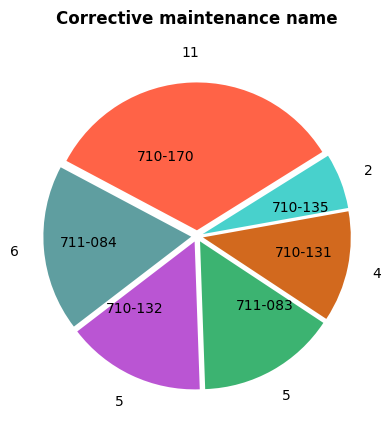

In [93]:
corr_maint_040_TCU['Wagon'].value_counts()

sizes_wagon = corr_maint_040_TCU['Wagon'].value_counts().tolist()
labels_wagon = corr_maint_040_TCU['Wagon'].value_counts().index
def absolute_values(val):
    absolute = int(val / 100 * sum(sizes_wagon))
    return f'{absolute:,}'

fig, ax = plt.subplots()
ax.pie(sizes_wagon, labels=labels_wagon, explode=[0.04]*len(labels_wagon == "710-170"), autopct=absolute_values, pctdistance=1.2, labeldistance=.5, colors=['tomato', 'cadetblue','mediumorchid','mediumseagreen','chocolate','mediumturquoise'], startangle=32)
plt.title('Corrective maintenance name', pad=20, fontweight='bold')
plt.savefig('corr_maint_name.png', transparent=True)
plt.show()

In [94]:
# 6) check depot and wagon values of alerts during the corrective maintenances:
start_corr_maint = corr_maint_040_TCU['Start_date']
end_corr_maint = corr_maint_040_TCU['End_date']
#print(start_corr_maint)
#print(end_corr_maint)

#print(len(list(zip(start_corr_maint, end_corr_maint))))
#print(list(zip(start_corr_maint, end_corr_maint)))
#print("\n")

log_during_corr_maintenance = pd.DataFrame()
for start, end in zip(start_corr_maint, end_corr_maint):
    #print(start, end)
    mask = data2[(data2['Date'] >= start) & (data2['Date'] <= end)]
    log_during_corr_maintenance = pd.concat([log_during_corr_maintenance, mask])
    #log_during_maintenance.loc[len(mask)] = mask
log_during_corr_maintenance.reset_index(drop=True, inplace=True)


#   a) all alerts during maintenances:
print("a) all alerts during maintenances:")
print(log_during_corr_maintenance)   # length: 730440
print("\n")
print(log_during_corr_maintenance['depot'].value_counts())   # 0-->678617 and 1-->51823
print("\n")

#count = 0
for start, end in zip(start_corr_maint, end_corr_maint):
    if pd.isna(start):
        #count += 1
        continue
    print(f"-maintenance from {start} to {end} :")
    print(f"wagon for which the maintenance is required: {corr_maint_040_TCU[(corr_maint_040_TCU['Start_date'] >= start) & (corr_maint_040_TCU['End_date'] <= end)]['Wagon'].tolist()}")
    mask = log_during_corr_maintenance[(log_during_corr_maintenance['Date'] >= start) & (log_during_corr_maintenance['Date'] <= end)]
    print(f"where alerts have been tested during the maintenance: \n{mask['name'].value_counts()}")
    print(f"where alerts have been tested during the maintenance: \n{mask['depot'].value_counts()}")
    print("\n")
#count


#   b) alerts in depot:
print("b) alerts in depot during maintenances:")
log_corr_maintenance_depot1 = log_during_corr_maintenance[log_during_corr_maintenance['depot'] == 1]
print(log_corr_maintenance_depot1['name'].value_counts())
print("\n")

#count = 0
for start, end in zip(start_corr_maint, end_corr_maint):
    if pd.isna(start):
        #count += 1
        continue
    print(f"-maintenance from {start} to {end} :")
    print(f"wagon for which the maintenance is required: {corr_maint_040_TCU[(corr_maint_040_TCU['Start_date'] >= start) & (corr_maint_040_TCU['End_date'] <= end)]['Wagon'].tolist()}")
    mask = log_corr_maintenance_depot1[(log_corr_maintenance_depot1['Date'] >= start) & (log_corr_maintenance_depot1['Date'] <= end)]
    print(f"where alerts have been tested during the maintenance: \n{mask['name'].value_counts()}")
    print(f"where alerts have been tested during the maintenance: \n{mask['depot'].value_counts()}")
    print("\n")
#count

a) all alerts during maintenances:
         source     name machine_type alert_type             ts  cod  id  id1  \
0       711-083  710-170           MD        PDM  1605019470000    5  15    0   
1       711-083  710-170           MS        PDM  1605019467000    5  15    0   
2       711-083  710-170           MS        PDM  1605019438000    5  15    0   
3       711-083  710-170           MS        PDM  1605019425000    5  15    0   
4       711-083  710-170           MS        PDM  1605018401000    5  15    0   
...         ...      ...          ...        ...            ...  ...  ..  ...   
188471  711-084  711-084           MS        PDO  1706176869000    5  98   10   
188472  711-084      NaN           MS   TrainSet  1706177618000    0   0    0   
188473  711-084  710-170           MS        PDM  1706177620000    5  15    0   
188474  711-084  711-084           MS        PDO  1706177620000    5  98   10   
188475  711-084  711-084           MD        PDO  1706178631000    5  98  

## Save all the datasets

In [16]:
#   a) csv:
sched_maint_040_complete.to_csv('Final_dataset//sched_maint_040.csv', index=False)
correct_maint_complete.to_csv('Final_dataset//correct_maint_040_complete.csv', index=False)
corr_maint_040_TCU.to_csv('Final_dataset//correct_maint_040_TCU.csv', index=False)

#   b) parquet:
sched_maint_040_complete.to_parquet('Final_dataset//sched_maint_040.parquet', engine='fastparquet')
correct_maint_complete.to_parquet('Final_dataset//correct_maint_040_complete.parquet', engine='fastparquet')
corr_maint_040_TCU.to_parquet('Final_dataset//correct_maint_040_TCU.parquet', engine='fastparquet')

In [17]:
# da scartare:

In [18]:
'''
# 3) find start date of each maintenance from log data --> idea is to find the proxy of the start date for each maintenance as the first alert with depot=0 before the end of the maintenance:

#   a) take the alerts with depot=1 and date=end_date of the maintenances (unique):
log_enddate_depot1 = pd.DataFrame()
for i in corrective_maintenance['End_date'].unique():
    mask = data2[(data2['Date'] == i) & (data2['depot'] == 1)]
    log_enddate_depot1 = pd.concat([log_enddate_depot1, mask])
    #log_during_maintenance.loc[len(mask)] = mask
#log_enddate_depot1.reset_index(drop=True, inplace=True)
print(f"len of log_enddate_depot1: {len(log_enddate_depot1)}")   # length: 6884
print("\n")
print(f"head of log_enddate_depot1: \n{log_enddate_depot1.head()}")

#   b) we need only the first alert for each different end_date:
log_enddate_depot1_dropped = log_enddate_depot1.drop_duplicates('Date', keep='first')
print("\n")
print(f"log_enddate_depot1_dropped: \n{log_enddate_depot1_dropped}")

#   c) we search for the first alert with depot=0 before each of the alerts end_date and depot=1:
index = log_enddate_depot1_dropped.index
print("\n")
print(f"index: {index}")
print(f"len of index: {len(index)}")

start_date = []
for i in index:
    for k in range(1, 2000):
        riga = data2.loc[i-k]
        if(riga['depot'] == 0):
            start_date.append(riga['Date'])
            break
print("\n")
print(f"start dates: {start_date}")
print(f"len of start dates: {len(start_date)}")

#   d) combine start and end date of the maintenances:
log_enddate_depot1_dropped['start_date'] = start_date
#print(log_enddate_depot1_dropped)
dataset_appoggio = log_enddate_depot1_dropped[['Date','start_date']]
dataset_appoggio = dataset_appoggio.rename(columns={'Date': 'End_Date',
                                                    'start_date': 'Start_Date'})
dataset_appoggio['Duration'] = dataset_appoggio.apply(lambda x: x['End_Date'] - x['Start_Date'] + pd.Timedelta(days=1), axis=1)
print("\n")
print(f"start, end, duration of unique maintenances: \n{dataset_appoggio}")

#   e) add start date and duration to each corrective maintenance:
print("\n")
prova = corrective_maintenance['End_date'].isin(dataset_appoggio['End_Date'])
#print(prova)
print("\n")
#corrective_maintenance['boolean'] = prova
#print(corrective_maintenance)
#print("\n")
print(corrective_maintenance['boolean'])
print("\n")

start_date_complete = []
duration_complete = []
for i in range(len(corrective_maintenance)):
    print(i)
    if corrective_maintenance.loc[i, 'boolean'] == True:
        index_to_apply = dataset_appoggio.index[dataset_appoggio['End_Date'] == corrective_maintenance.loc[i, 'End_date']].tolist()
        print(index_to_apply)
        print(dataset_appoggio.loc[index_to_apply, 'Start_Date'].iat[0])
        print(dataset_appoggio.loc[index_to_apply, 'Duration'].iat[0])
        start_date_complete.append(dataset_appoggio.loc[index_to_apply, 'Start_Date'].iat[0])
        duration_complete.append(dataset_appoggio.loc[index_to_apply, 'Duration'].iat[0])
    else:
        start_date_complete.append("no log")
        duration_complete.append("no log")
        print("no log")
print("\n")
print(f"start date column: \n{start_date_complete}")
print("\n")
print(f"duration column: \n{duration_complete}")
corrective_maintenance['Start_date'] = start_date_complete
corrective_maintenance['Duration'] = duration_complete
print("\n")
print(corrective_maintenance)

# f) create the final version:
print(corrective_maintenance.columns)
correct_maint_complete = corrective_maintenance.drop(columns=['Inizio guasto', 'Fine guasto', 'boolean'])
correct_maint_complete = correct_maint_complete[['Avviso', 'Train', 'Wagon', 'N. invent.', 'Type', 'Treno', 'Group_maint_source', 'Descrizione',
       'Testo esteso', 'Testo interv.', 'Desc.Interv.', 'Testo est. provved.',
       'Start_date', 'End_date', 'Duration']]
print("\n")
print(correct_maint_complete)
print("\n")
print(correct_maint_complete.info())
# start_date and duration are "objects" --> convert them into datetime and timedelta:
correct_maint_complete['Start_date_all_dates'] = correct_maint_complete['Start_date'].apply(lambda x: pd.to_datetime(pd.NaT) if x == 'no log' else pd.to_datetime(x))
correct_maint_complete['Duration_all_timedelta'] = correct_maint_complete['Duration'].apply(lambda x: pd.Timedelta(0) if x == 'no log' else pd.Timedelta(x))
correct_maint_complete = correct_maint_complete.drop(columns=['Start_date', 'Duration'])
print("\n")
#correct_maint_040_complete = correct_maint_040_complete[['Train', 'Type', 'Level', 'Km', 'Start_date_all_dates', 'End_date', 'Duration_all_timedelta']]
correct_maint_complete.rename(columns={'Start_date_all_dates': 'Start_date', 'Duration_all_timedelta': 'Duration'}, inplace=True)
print(correct_maint_complete.info())
print("\n")
print(correct_maint_complete)
print("\n")
'''

'\n# 3) find start date of each maintenance from log data --> idea is to find the proxy of the start date for each maintenance as the first alert with depot=0 before the end of the maintenance:\n\n#   a) take the alerts with depot=1 and date=end_date of the maintenances (unique):\nlog_enddate_depot1 = pd.DataFrame()\nfor i in corrective_maintenance[\'End_date\'].unique():\n    mask = data2[(data2[\'Date\'] == i) & (data2[\'depot\'] == 1)]\n    log_enddate_depot1 = pd.concat([log_enddate_depot1, mask])\n    #log_during_maintenance.loc[len(mask)] = mask\n#log_enddate_depot1.reset_index(drop=True, inplace=True)\nprint(f"len of log_enddate_depot1: {len(log_enddate_depot1)}")   # length: 6884\nprint("\n")\nprint(f"head of log_enddate_depot1: \n{log_enddate_depot1.head()}")\n\n#   b) we need only the first alert for each different end_date:\nlog_enddate_depot1_dropped = log_enddate_depot1.drop_duplicates(\'Date\', keep=\'first\')\nprint("\n")\nprint(f"log_enddate_depot1_dropped: \n{log_endda

In [19]:
'''
#   a) take the alerts with depot=1 and date=end_date of the maintenances (unique):
log_enddate_depot1 = pd.DataFrame()
for i in corrective_maintenance['End_date'].unique():
    mask = data2[(data2['Date'] == i) & (data2['depot'] == 1)]
    log_enddate_depot1 = pd.concat([log_enddate_depot1, mask])

print(f"len of log_enddate_depot1: {len(log_enddate_depot1)}")   # length: 20504
print("\n")
print(f"head of log_enddate_depot1: \n{log_enddate_depot1.head()}")


#   b) we need only the first alert for each different end_date:
log_enddate_depot1_dropped = log_enddate_depot1.drop_duplicates('Date', keep='first')
print("\n")
print(f"log_enddate_depot1_dropped: \n{log_enddate_depot1_dropped}")

# c) we need to take also the corresponding start of the ticket:
end_date_final = log_enddate_depot1_dropped['Date']
print(end_date_final)   # 81
print("\n")

index_end_date = corrective_maintenance[corrective_maintenance['End_date'].isin(end_date_final)].index
print(index_end_date) # 117
print("\n")

cutted_end_date = corrective_maintenance.loc[index_end_date]
print(cutted_end_date)
cutted_end_date_dropped = cutted_end_date.drop_duplicates('End_date', keep='first')
print("\n")
print(cutted_end_date_dropped)  # 81
print("\n")

cutted_end_date_final = cutted_end_date_dropped['End_date']
print(cutted_end_date_final)
print("\n")

count = 0
for i in range(len(end_date_final)):
    for k in range(len(cutted_end_date_final)):
        if end_date_final.iloc[i] == cutted_end_date_final.iloc[k]:
            count += 1
print(count)    # = 81 --> QUINDI DOVREMMO ESSERE APPOSTO
print("\n")

index_cutted_end_date_dropped = cutted_end_date_dropped.index
print(len(index_cutted_end_date_dropped))   # =81
print("\n")

start_date_final = corrective_maintenance.loc[index_cutted_end_date_dropped, 'Start_date']
print(start_date_final)     # =81 --> DOVREMMO ESSERCI
print("\n")

zipped_list = list(zip(start_date_final, cutted_end_date_final))
print(zipped_list)
print("\n")
for start_final,end_final in zip(start_date_final, cutted_end_date_final):
    print(end_final - start_final)

dict = {}
for i,k in zip(start_date_final, cutted_end_date_final):
    dict[k] = i
    #print(type(k))
print(dict)
#   c) we search for the first alert with depot=0 occurred after start but before each of the alerts end_date and depot=1:
index = log_enddate_depot1_dropped.index
print("\n")
print(f"index: {index}")
print(f"len of index: {len(index)}")    # =81

start_date = []
for i in index:
    k= 0
    while True:
        riga = data2.loc[i-k]
        data_end = riga['Date']
        if data_end in dict.keys():
            data_start = dict[data_end]
            if(riga['depot'] == 0):
                start_date.append(riga['Date'])
                break
            if data_end > data_start:
                break
        k = k+1
            
print("\n")
print(f"start dates: {start_date}")
print(f"len of start dates: {len(start_date)}")
'''

'\n#   a) take the alerts with depot=1 and date=end_date of the maintenances (unique):\nlog_enddate_depot1 = pd.DataFrame()\nfor i in corrective_maintenance[\'End_date\'].unique():\n    mask = data2[(data2[\'Date\'] == i) & (data2[\'depot\'] == 1)]\n    log_enddate_depot1 = pd.concat([log_enddate_depot1, mask])\n\nprint(f"len of log_enddate_depot1: {len(log_enddate_depot1)}")   # length: 20504\nprint("\n")\nprint(f"head of log_enddate_depot1: \n{log_enddate_depot1.head()}")\n\n\n#   b) we need only the first alert for each different end_date:\nlog_enddate_depot1_dropped = log_enddate_depot1.drop_duplicates(\'Date\', keep=\'first\')\nprint("\n")\nprint(f"log_enddate_depot1_dropped: \n{log_enddate_depot1_dropped}")\n\n# c) we need to take also the corresponding start of the ticket:\nend_date_final = log_enddate_depot1_dropped[\'Date\']\nprint(end_date_final)   # 81\nprint("\n")\n\nindex_end_date = corrective_maintenance[corrective_maintenance[\'End_date\'].isin(end_date_final)].index\npr

In [20]:
'''
# extra) extract all starts and ends in order to highlight them into the timestamp plot in EDA:
start_sched_maint_full = sched_maint_040_complete['Start_date']
end_sched_maint_full = sched_maint_040_complete['End_date']

%store start_sched_maint_full
%store end_sched_maint_full
'''

"\n# extra) extract all starts and ends in order to highlight them into the timestamp plot in EDA:\nstart_sched_maint_full = sched_maint_040_complete['Start_date']\nend_sched_maint_full = sched_maint_040_complete['End_date']\n\n%store start_sched_maint_full\n%store end_sched_maint_full\n"

In [21]:
'''
# extra) extract all start and ends in order to highlight them into the timestamp plot in EDA:
start_correct_maint_full = correct_maint_complete['Start_date']
end_correct_maint_full = correct_maint_complete['End_date']

%store start_correct_maint_full
%store end_correct_maint_full
'''

"\n# extra) extract all start and ends in order to highlight them into the timestamp plot in EDA:\nstart_correct_maint_full = correct_maint_complete['Start_date']\nend_correct_maint_full = correct_maint_complete['End_date']\n\n%store start_correct_maint_full\n%store end_correct_maint_full\n"